In [1]:
import os
import sys
import scipy.sparse as sparse
import numpy as np
import pickle
from sklearn.manifold import TSNE
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
loc = "feature-sef-df.pkl"

## First let's look at the data

In [4]:
results = pickle.load(open(loc,'rb'))

In [5]:
results.head()

,Apt__liblockfile-dev,Pip__pytrends,Apt__libipmidetect0,Apt__qtenginio5-doc,Apt__ros-indigo-eigen-conversions,Apt__marble-data,Apt__libapache2-mod-php5.6,Apt__dde-desktop,Apt__libopus-dev,Apt__libscope-guard-perl,...,Apt__appmenu-qt5,Apt__zimbra-lmdb,Apt__thunar-data,Apt__cuda-nvgraph-dev-9-2,Apt__libomp5-7,Apt__libcloog-pplv4-1,Apt__libevent-core-2.0-5,Apt__zimbra-perl-io-compress,Apt__llvm-8-runtime,Apt__libjpeg8-dev
kurioapps/apib-tool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kblr/ubuntu18.04-ansible,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
citizenlabdotco/cl-devops-docs-portal-buildenv,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jesusmatosp/docker-web,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jaysong/sails,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
# Oh wow, it's super sparse! How sparse is it?

## Percent sparse
sum(sum(results.values)) / (results.shape[0] * results.shape[1])

0.004922280211511118

In [7]:
## lil_matix is fast to build
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html
M = sparse.lil_matrix(np.array(results.values, dtype=int))

In [8]:
# Compressed Sparse Row Matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
M = sparse.csr_matrix(M)  ## csr matrix is fast to work with

In [9]:
M

<6278x32913 sparse matrix of type '<class 'numpy.int64'>'
	with 1017080 stored elements in Compressed Sparse Row format>

In [224]:
def sparse_size(a):
    return  a.data.nbytes + a.indptr.nbytes + a.indices.nbytes

In [229]:
sparse_size(M)/1e6 ## size in MB

12.336616

## Preliminary analysis: truncated SVD to 2 dimensions

In [14]:
# Truncated SVD (singular value decomposition) means we don't center the data first.
# So it works well for sparse data
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD()
T = tsvd.fit_transform(M)
print(tsvd.explained_variance_ratio_)
print(tsvd.explained_variance_ratio_.sum())

[0.37019163 0.10112333]
0.4713149586435458


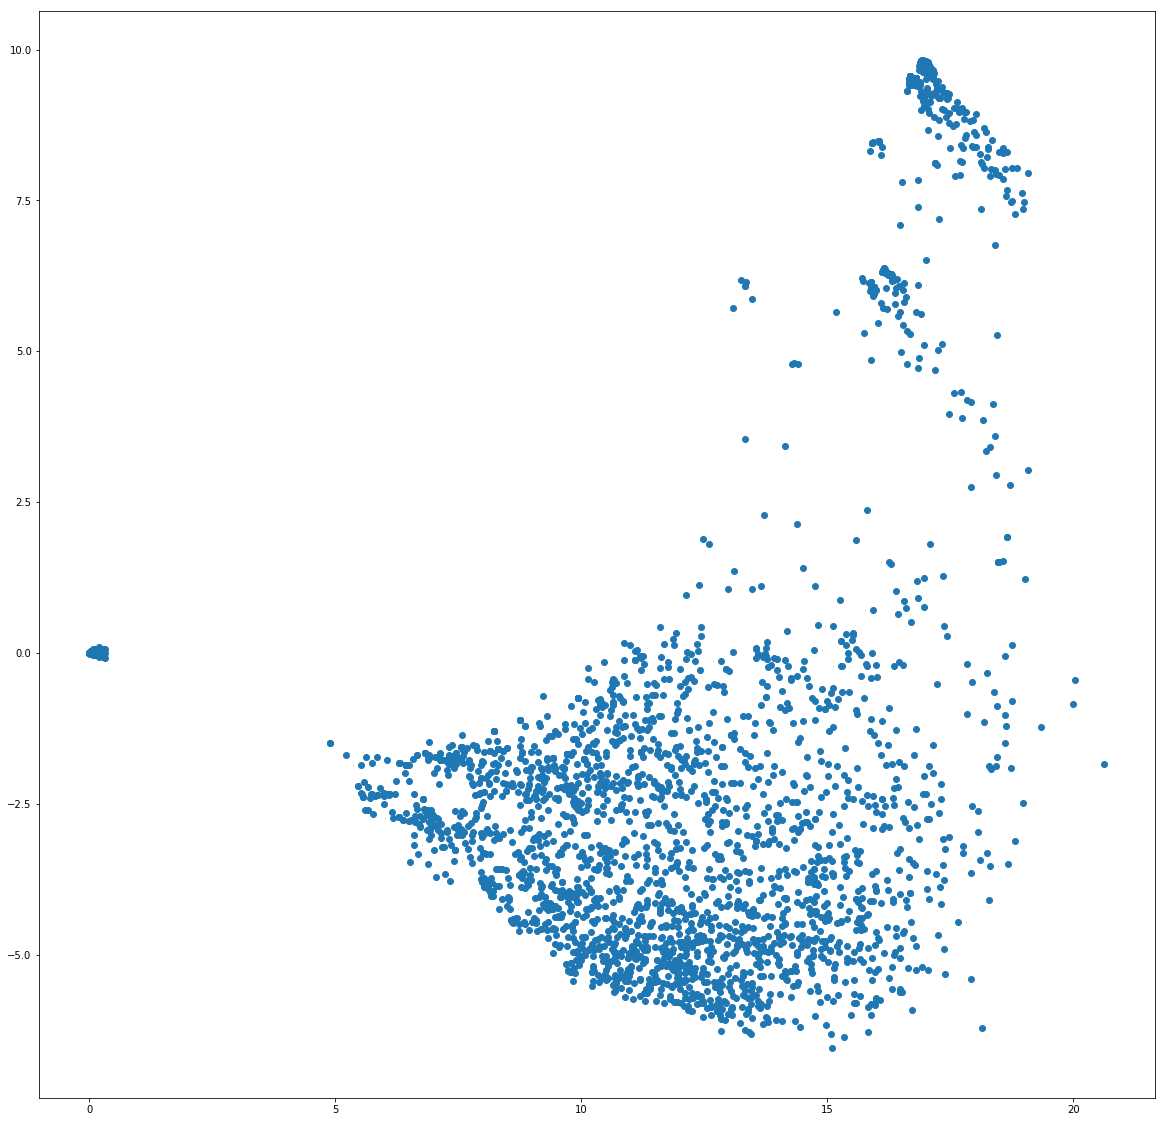

In [15]:
plt.figure(figsize=(20,20))
plt.scatter(*T.T)

## Next, we'll follow up a linear analysis by T-SNE for visualization purposes

In [22]:
tsvd = TruncatedSVD(n_components=200)
T = tsvd.fit_transform(M)

# Let's load some labels! These are rough, but will do the trick to show *some* signal
label_sets = pickle.load(open('df-labels-6k.pkl','rb'))
print(label_sets.keys())

dict_keys(['notag', 'images', 'fromheaders'])


In [23]:
# Above we see that we have labels: as they are originally e.g., <library>/<image>:<tag
#                                   without tags e.g.,           <library>/<image>
#                                   without library or tag name  <image>
#
# The last one is most general and good for our labeling here!                                   
tsne = TSNE(n_components=2)

In [24]:
NT = tsne.fit_transform(T)

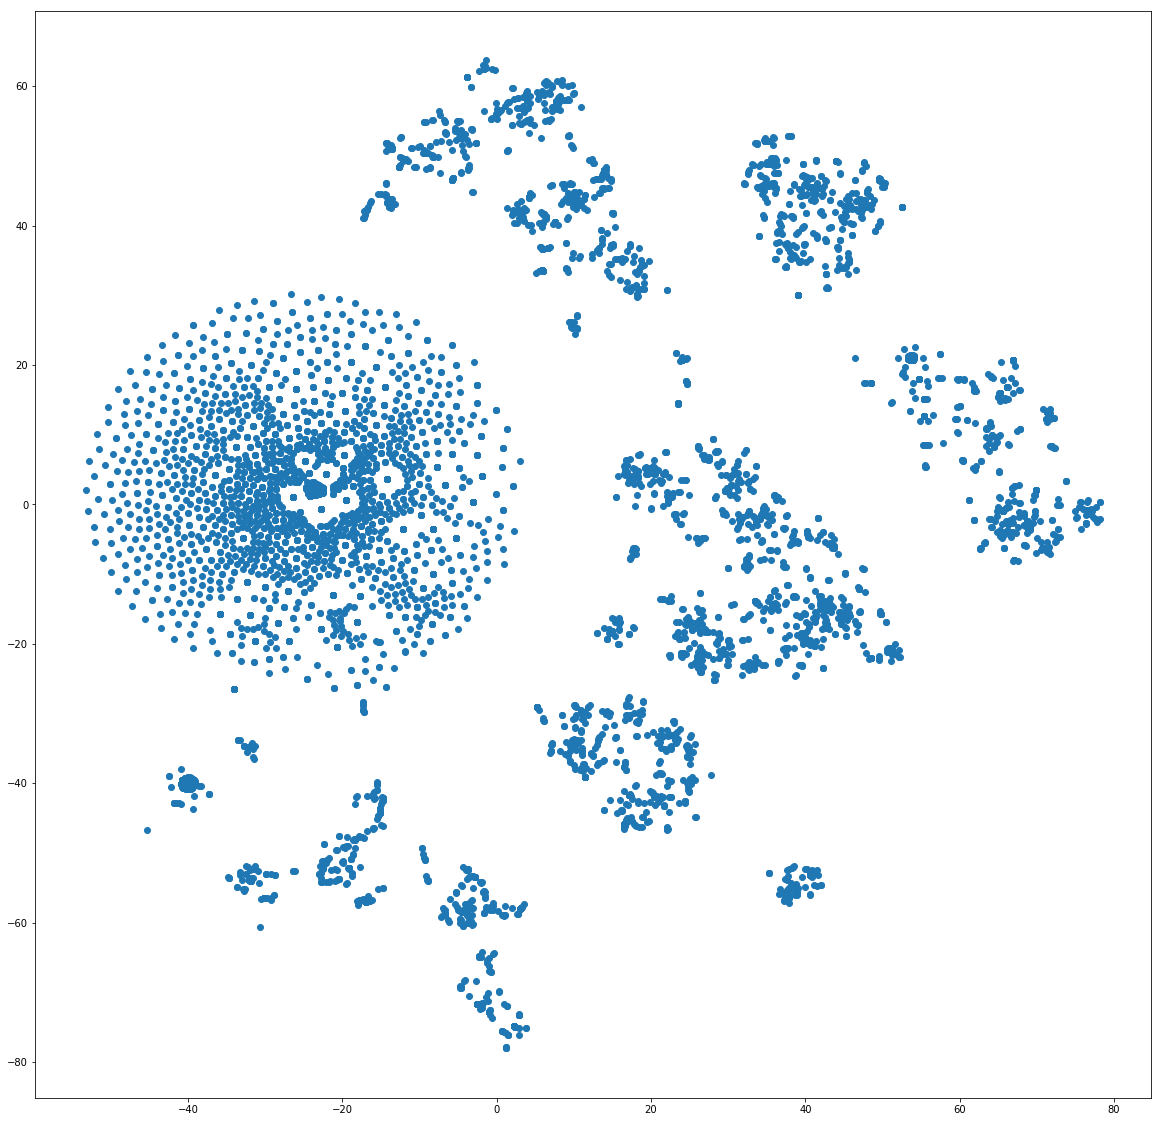

In [25]:
plt.figure(figsize=(20,20))
plt.scatter(*NT.T)

## Labeling

Let's see if we can give meaning to the image by labeling some of the clusters. First, let's write a function that will plot the same data based on finding a substring in a package.

In [59]:
def label_by_package_name(results, keywords, NT):
    '''plot the TSNE transform based on coloring containers that contain
       a software dependency that has one or more keywords (entirely or as
       subtring)
       
       Parameters
       ==========
       results: the pandas df, we get the index (container names) from here
       keywords: one or more keywords to look for in the df.columns
       NT: the transform from  (NT = tsne.fit_transform(T))
    '''
    packages = list(results.iloc[0].index)

    # Ensure we have a list of keywords
    if not isinstance(keywords, list):
        keywords = [keywords]
        
    # Which packages have the keywords?
    has_keywords = [i for (i, s) in enumerate(packages) if any(k in s for k in keywords)] 
    print('Found %s with keywords %s' %(len(has_keywords), ','.join(keywords)))

    # Make it sparse again!
    M = sparse.lil_matrix(np.array(results.values, dtype=int))
    M = sparse.csc_matrix(M)  ## csr matrix is fast to work with
    
    with_keywords = list(set(filter_rows_by_columns(M, has_keywords)))
    without_keywords = list(set(range(M.shape[0])) - set(with_keywords))
    
    points_with_keywords = NT[with_keywords, :]
    points_without_keywords = NT[without_keywords, :]
    
    plt.figure(figsize=(20,20))
    plt.title("With keywords %s" %','.join(keywords), fontsize=24)
    plot_with_keywords = plt.scatter(*points_with_keywords.T, c='b')
    plot_without_keywords = plt.scatter(*points_without_keywords.T, c='r')
    plt.legend( (plot_with_keywords, plot_without_keywords), ("with keyword " + "".join(keywords),
                                                              "without keyword "), fontsize=24)
    plt.show()
    return plt

def filter_rows_by_columns(M, columns):
    """Efficient method for filtering rows (aka container) by columns (aka package)"""
    rows = []
    for c in columns:  ## iterate through columns
        for ind in range(M.indptr[c], M.indptr[c+1]):
            if M.data[ind]:
                rows.append(M.indices[ind])
    return rows

Found 99 with keywords manager


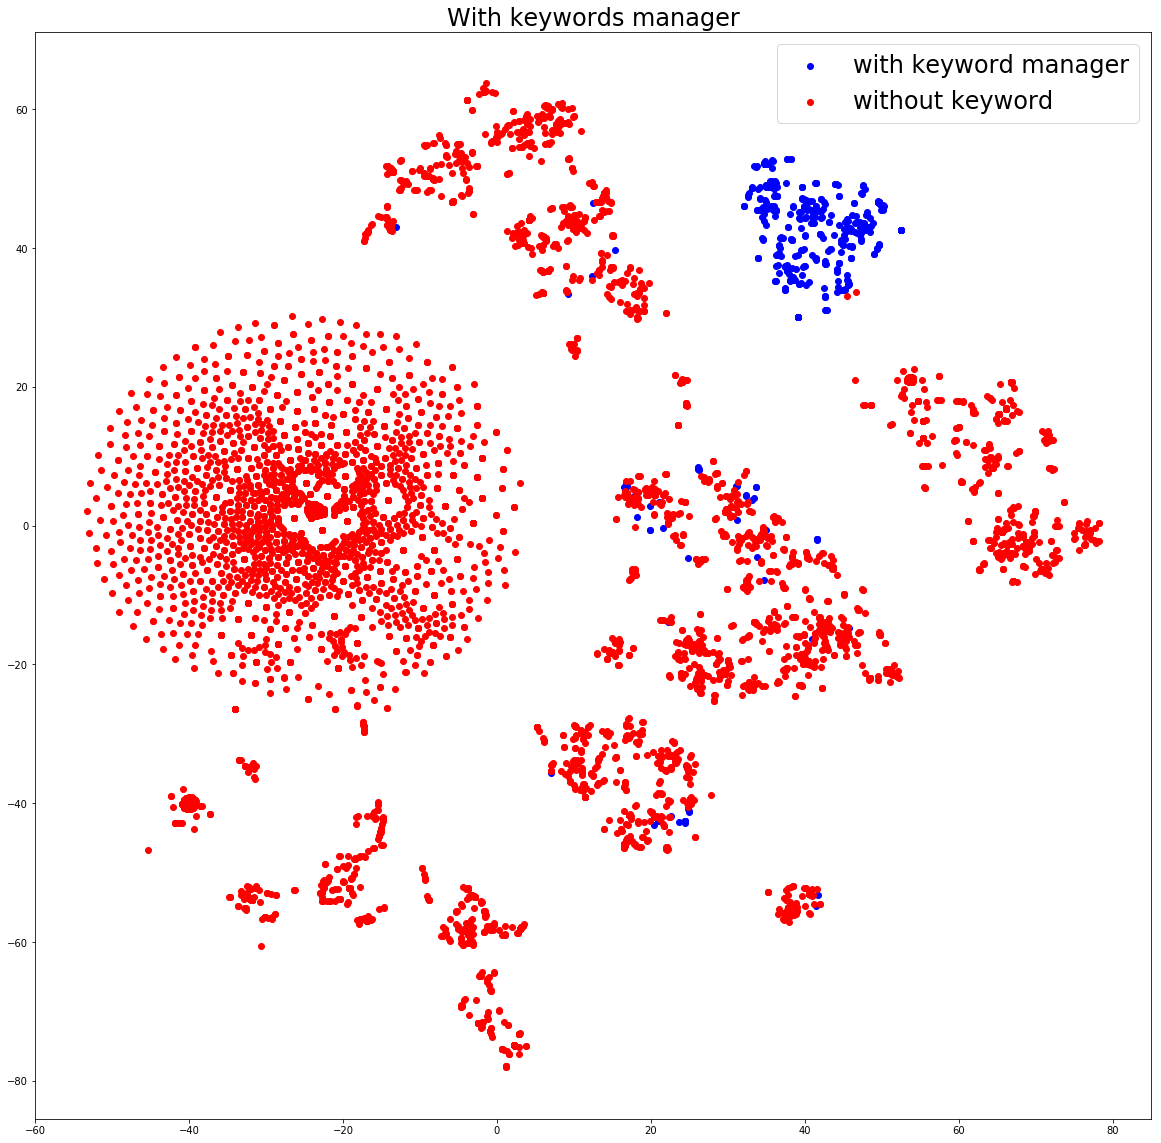

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [60]:
# Now run the algorithm!
label_by_package_name(results, ["manager"], NT)

Found 4687 with keywords Pip


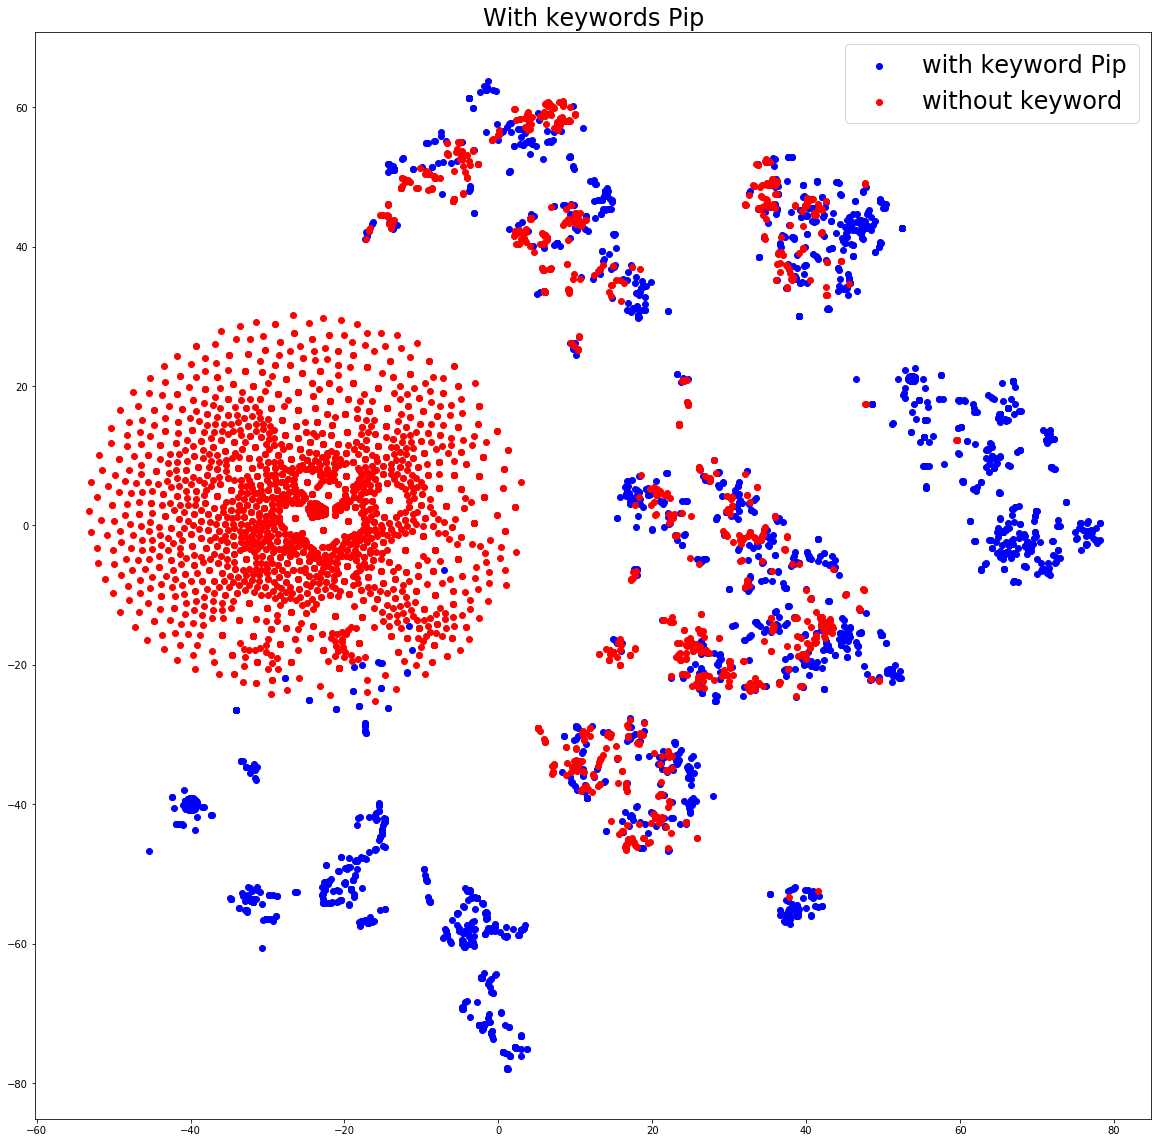

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [61]:
label_by_package_name(results, ["Pip"], NT)

Found 28226 with keywords Apt


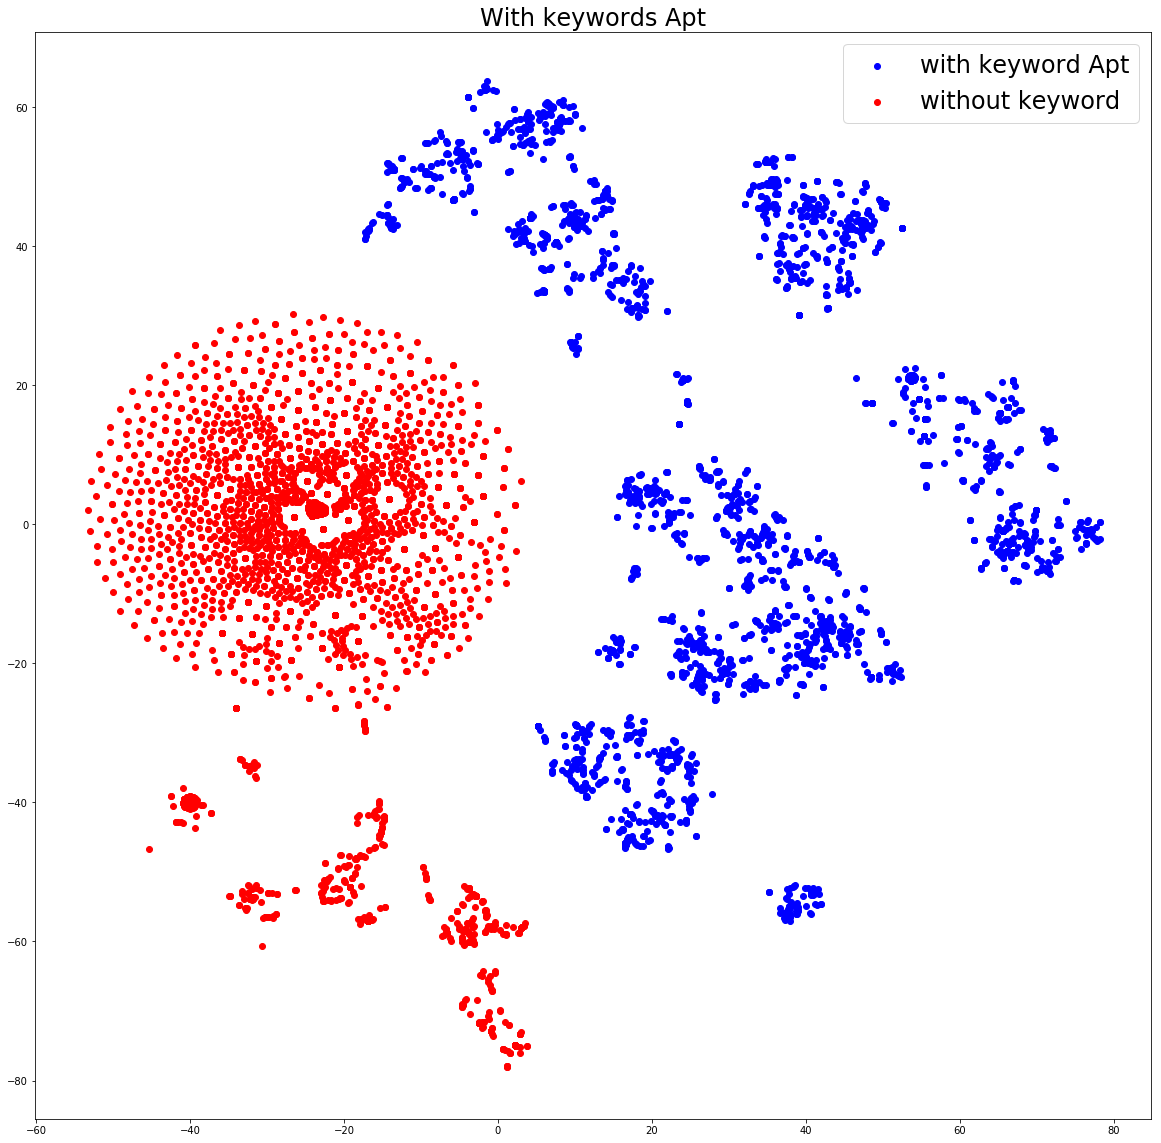

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [62]:
# It follows the rest have apt...
label_by_package_name(results, ["Apt"], NT)

Found 11632 with keywords lib


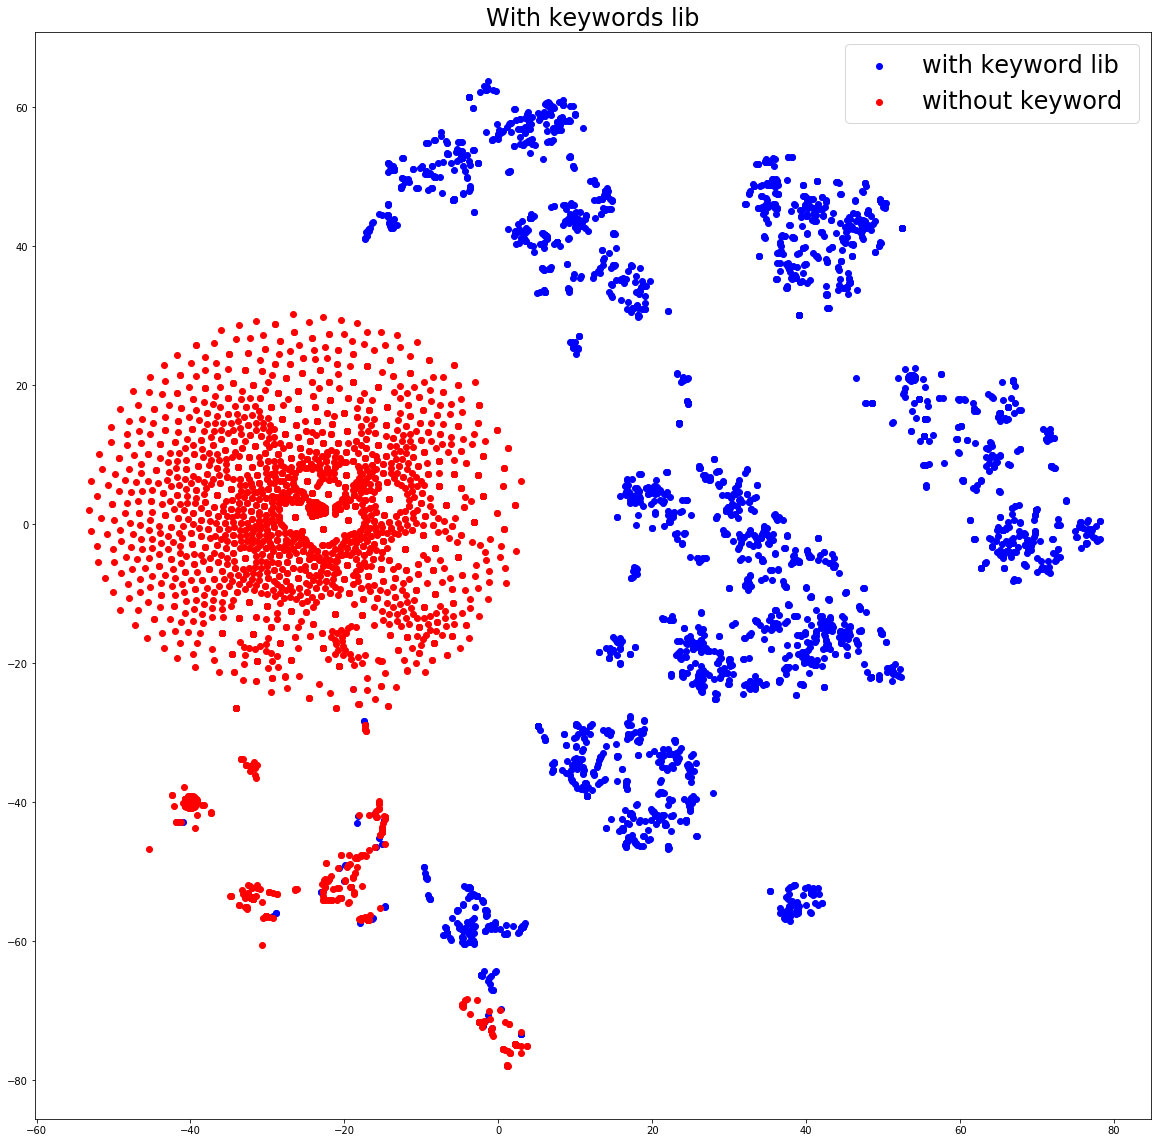

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [63]:
# This suggests most of the apt installs have lib :)
label_by_package_name(results, ["lib"], NT)

In [87]:
# Now let's use our labels and label by container names!

# Let's run this again just in case we lost it. I hate notebooks, I'm doing this for you! :P
label_sets = pickle.load(open('df-labels-6k.pkl','rb'))
print(label_sets.keys())

# How many unique?
print(len(set(label_sets['images'])))

dict_keys(['notag', 'images', 'fromheaders'])
1079


In [90]:
def label_by_container_name(results, bases, labels, NT):
    '''plot the TSNE transform based on coloring containers from a list
       of strings to identify them (e.g., container FROM names)
       
       Parameters
       ==========
       results: the pandas df, we get the index (container names) from here
       bases: some subset of bases we are interested in (e.g., debian)
       labels: a list of labels
       NT: the transform from  (NT = tsne.fit_transform(T))
    '''

    has_bases = []
    without_bases = []
    for i in range(len(labels)):
        label = labels[i]
        if label in bases:
            has_bases.append(i)
        else:
            without_bases.append(i)

    print('Found %s with bases %s' %(len(has_bases), ','.join(bases)))

    # Make it sparse again!
    M = sparse.lil_matrix(np.array(results.values, dtype=int))
    M = sparse.csc_matrix(M)  ## csr matrix is fast to work with
        
    points_with_bases = NT[has_bases, :]
    points_without_bases = NT[without_bases, :]
    
    plt.figure(figsize=(20,20))
    plt.title("With bases %s" %','.join(bases), fontsize=24)
    plot_with_bases = plt.scatter(*points_with_bases.T, c='b')
    plot_without_bases = plt.scatter(*points_without_bases.T, c='r')
    plt.legend( (plot_with_bases, plot_without_bases), ("with bases " + ",".join(bases),
                                                        "without"), fontsize=24)
    plt.show()
    return plt

# Yes, redundant, it's okay

Found 1599 with bases ubuntu,debian


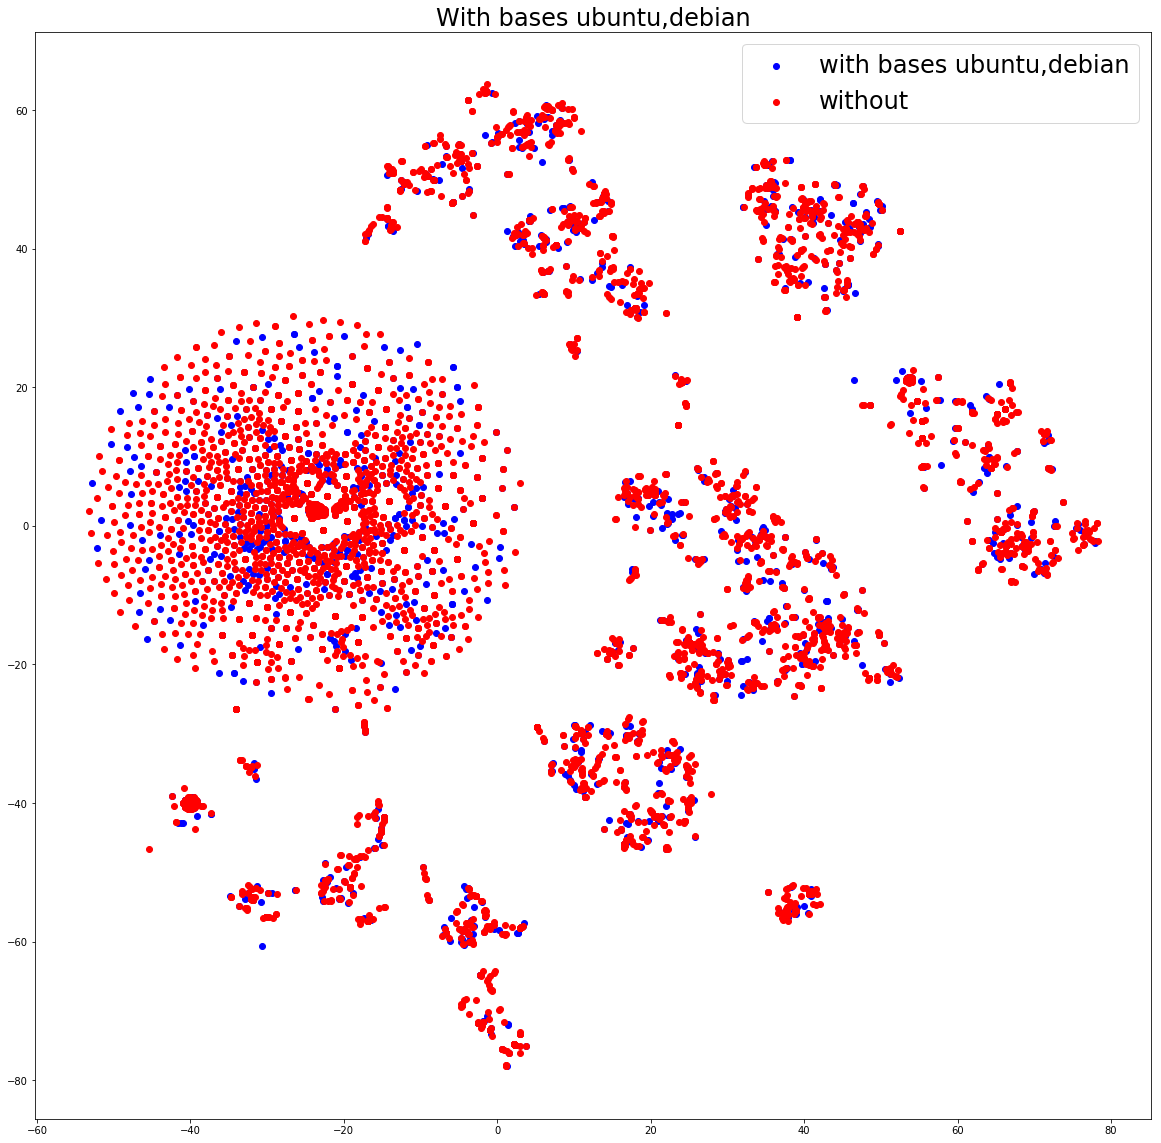

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [92]:
label_by_container_name(results, ["ubuntu", "debian"], label_sets['images'], NT)

Found 533 with bases alpine


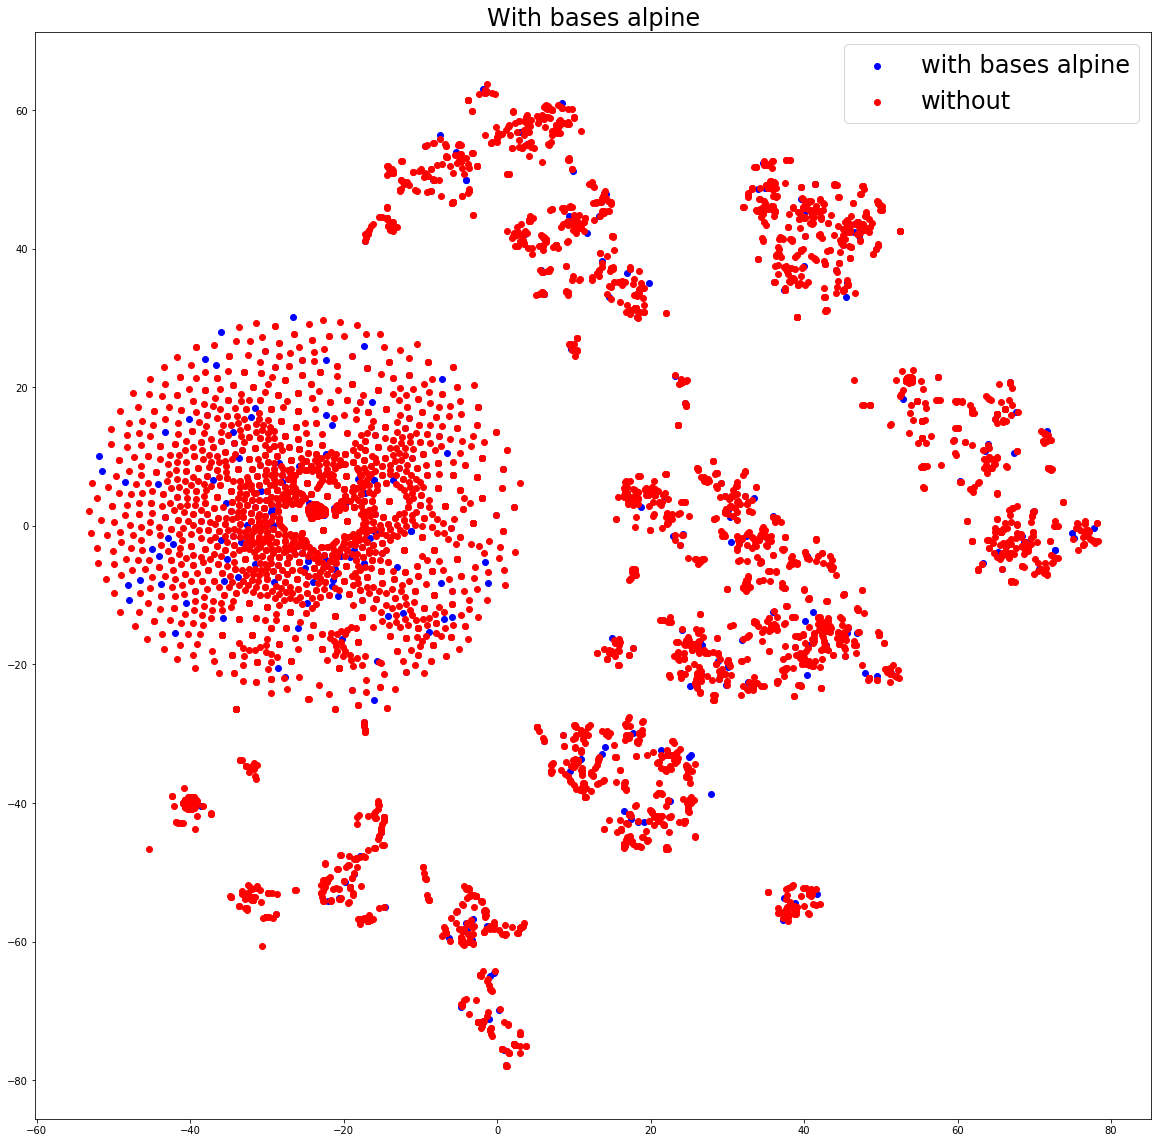

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [93]:
label_by_container_name(results, ["alpine"], label_sets['images'], NT)

Found 667 with bases python


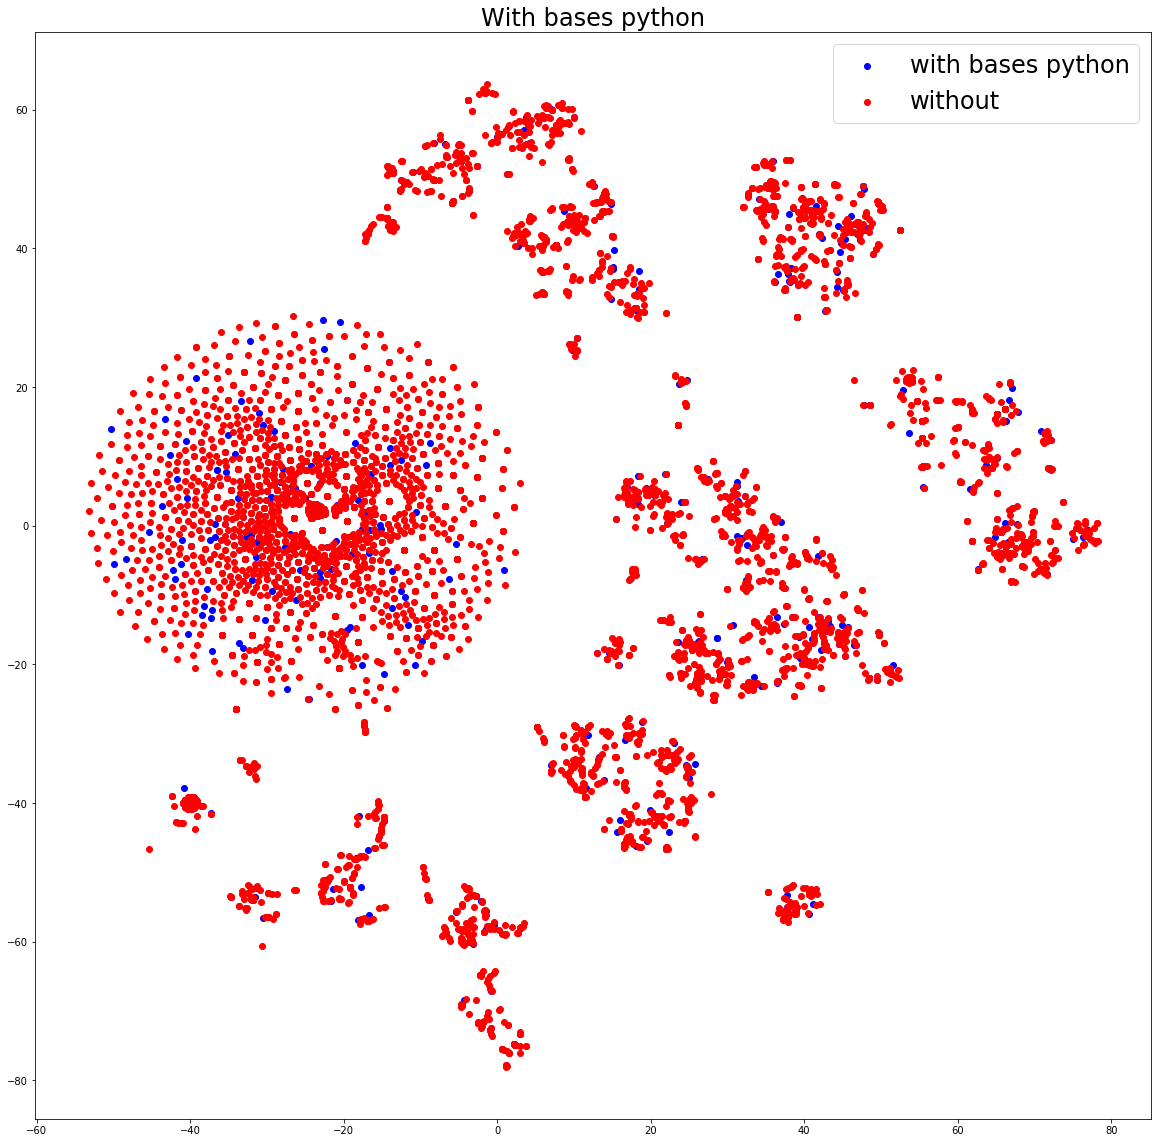

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [94]:
label_by_container_name(results, ["python"], label_sets['images'], NT)

In [102]:
# Let's look at counts
counts = dict()
for label in label_sets['images']:
    if label not in counts:
        counts[label] = 0
    counts[label] += 1
    
sorted(counts, key=counts.get, reverse=True)

['ubuntu',
 'python',
 'alpine',
 'debian',
 'node',
 'centos',
 'phusion',
 'php',
 'ruby',
 'golang',
 'nginx',
 'openjdk',
 'java',
 'mhart',
 'fedora',
 'jupyter',
 'scratch',
 'docker',
 'gcr.io',
 'continuumio',
 'nvidia',
 'postgres',
 'gliderlabs',
 'microsoft',
 'rocker',
 'jenkins',
 'maven',
 'dockerfile',
 'quay.io',
 'busybox',
 'lsiobase',
 'frolvlad',
 'buildpack-deps',
 'tomcat',
 'tutum',
 'anapsix',
 'circleci',
 'from ubuntu',
 'tensorflow',
 'google',
 'mongo',
 'openshift',
 'library',
 'httpd',
 'resin',
 'sameersbn',
 'docker.elastic.co',
 'mysql',
 'base',
 'haproxy',
 'hivesolutions',
 'heroku',
 'rabbitmq',
 'tiangolo',
 'tiredofit',
 'from python',
 'jwilder',
 'mono',
 'docker.io',
 'hilbert',
 'gitlab',
 '1and1internet',
 'certbot',
 'jenkinsci',
 'ipython',
 'jboss',
 'composer',
 'elasticsearch',
 'redis',
 'bitnami',
 'ros',
 'linuxserver',
 'haskell',
 'amazonlinux',
 'kaixhin',
 'wordpress',
 'progrium',
 'jupyterhub',
 'r-base',
 'gradle',
 'terragont

Found 332 with bases node


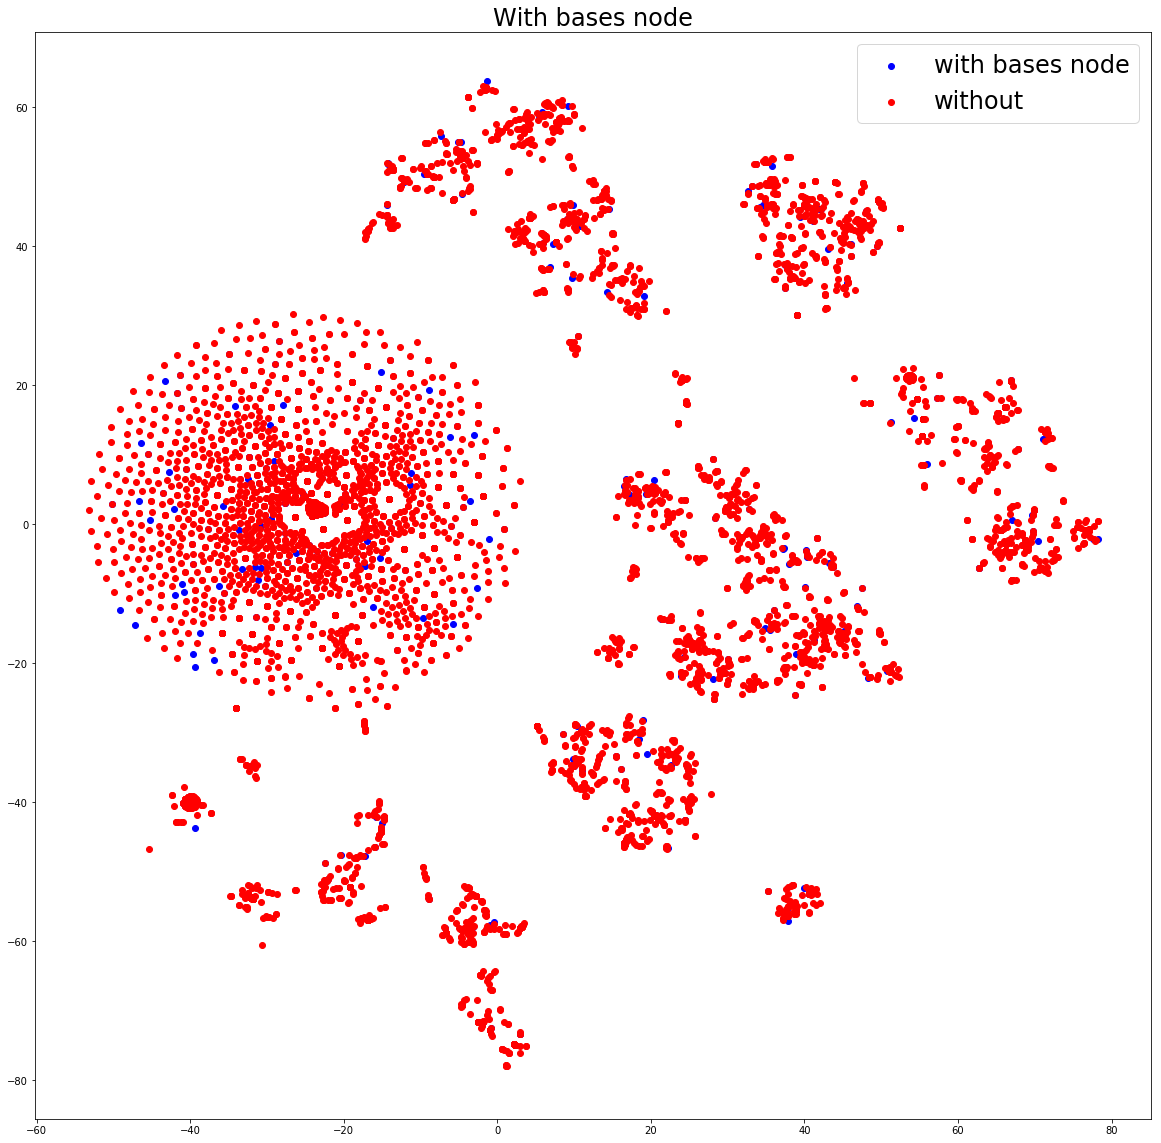

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [103]:
label_by_container_name(results, ["node"], label_sets['images'], NT)

In [ ]:
# What's clear from the above is that the base image offers little meaning to the cluster, but obviously
# the package type (apt vs pip) does. I'm not sure this helps us any.